In [9]:
import os
import random
from PIL import Image

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from scr import SCR

In [10]:
# Sample, Positive, Negative. By Style
class SCRDataset(Dataset):

    def __init__(self, path, num_neg=4):
        super().__init__()
        self.path = path
        self.resolution = 96 # default
        self.num_neg = num_neg
        self.all_files = [path+"pngs/"+f for f in os.listdir(path+"pngs/") if ".png" in f]
        self.all_korean_letters = pd.read_parquet(path+"all_korean.parquet")
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.all_files)
        
    def __getitem__(self, index):
        sample_img_path = self.all_files[index]
        sample_img_name = sample_img_path.replace(".png","").split('__')
        style = sample_img_name[0]
        
        pos_img_paths = [f for f in self.all_files if (style in f) & (sample_img_path != f)]
        pos_img_path = random.choice(pos_img_paths)
        
        sample_img = self.transform(Image.open(sample_img_path).convert("RGB"))
        pos_img = self.transform(Image.open(pos_img_path).convert("RGB"))
        
        neg_imgs = []
        neg_img_paths = [f for f in self.all_files if (style not in f) & ("__%s"%sample_img_name[1] in f)]
        for _ in range(self.num_neg):
            neg_img_path = random.choice(neg_img_paths)
            neg_imgs.append(self.transform(Image.open(neg_img_path).convert("RGB")))
        
        # sample_img = Image.open(sample_img_path).convert("RGB")
        # pos_img = Image.open(pos_img_path).convert("RGB")
        # neg_img = Image.open(neg_img_path).convert("RGB")
        
        return sample_img, pos_img, torch.stack(neg_imgs)

In [11]:
scr_ds = SCRDataset(path="data/r40202/")
scr_dl = DataLoader(scr_ds, shuffle=True, batch_size=64, num_workers=4)

In [12]:
scr_model = SCR()
scr_model = scr_model.cuda()

In [13]:
optimizer = torch.optim.AdamW(scr_model.parameters(), lr=1e-5)

In [14]:
epoch = 100
save_fd = "data/m40208/"

In [ ]:
lossdicts = []
for epoch_i in range(epoch):
    pbar = tqdm(scr_dl)
    losses = []
    for x in pbar:
        optimizer.zero_grad()

        sample_img, pos_img, neg_imgs = x
        sample_emb, pos_emb, neg_emb = scr_model(sample_img.cuda(), pos_img.cuda(), neg_imgs.cuda())
        loss = scr_model.calculate_nce_loss(sample_emb, pos_emb, neg_emb)

        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        pbar.set_postfix(loss=str(np.mean(losses)))
    lossdicts.append({"loss":np.mean(losses)})
    pd.DataFrame().from_dict(lossdicts).to_csv(save_fd+"loss.csv")
    torch.save(scr_model.state_dict(), save_fd+"m_%s.pth"%str(epoch_i))

 72%|███████▏  | 4390/6120 [3:31:33<1:52:29,  3.90s/it, loss=0.09295759] 

In [19]:
lossdicts

[{'loss': 1.6258091}, {'loss': 1.6270127}]

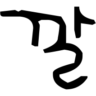

In [54]:
b

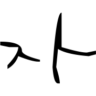

In [55]:
c

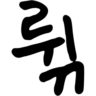

In [31]:
c